In [5]:
%%time
import segmind.instance as instance
import requests
import traceback
from datetime import datetime

try:
    #################################################
    # This is where your actual python code should be
    #################################################
    import numpy as np
    from scipy.integrate import solve_ivp
    from numpy.linalg import eig, eigh
    from scipy.special import j0, jn_zeros
    from multiprocessing import Pool
    from tqdm import tqdm
    import warnings
    warnings.filterwarnings('ignore')

    def floq_jac(t, h, h0, H1, H0, w):  
        drive = h0 + h * np.cos(w * t)
        return (-1j) * (H0  + drive * H1)           

    def floq_func(t,psi, h, h0, H1, H0, w):
        jac = floq_jac(t, h, h0, H1, H0, w)
        dpsidt = jac @ psi
        return dpsidt

    def floq_evolv(H0,H1,h,h0,w):
        n,m = H0.shape
        psi = np.eye(n) + (1j)* np.zeros(n)
        T = 2 * np.pi/w                                  
        floqEvolution_mat = np.zeros((n,n)) + 1j * np.zeros((n,n))
        for m in np.arange(n):
            psi0 = psi[m]/np.linalg.norm(psi[m])
            sol = solve_ivp(floq_func,(0,T),psi0,t_eval=[T], method='RK45',\
                            args=(h, h0, H1, H0, w), dense_output=True, rtol=1e-5, atol=1e-8)
            psi_T = sol.y[:,0]
            floqEvolution_mat[m] = psi_T/np.linalg.norm(psi_T)
        evals, evecs = eig(floqEvolution_mat)
        phasefunc = 1j * np.log(evals + 1j * 0) /T           
        return [h,phasefunc.real,evecs]

    def drive(t, args):
        w = args['w']
        h = args['h']
        h0 = args['h0']
        return h * np.cos(w*t) + h0

    def get_hamiltonians(N):
        s = 1/2.0
        ms = np.arange(-s,s+1/N, 1/N)
        KacNorm =  2.0/(N-1)    
        H0 = N**2 * KacNorm * 2 * np.diagflat(ms**2)  
        ms_p = ms[0:N] * N
        ms_m = ms[1:] * N

        sx_total = (np.diagflat(np.sqrt(N/2  * (N/2+1) - ms_p * (ms_p+1)), k=1)+\
                    np.diagflat(np.sqrt(N/2 * (N/2+1) - ms_m * (ms_m-1)), k=-1))
        H1 = sx_total
        return H0, H1

    def sx_evecs(N):
        s = 1/2.0
        ms = np.arange(-s,s+1/N, 1/N)
        ms_p = ms[0:N] * N
        ms_m = ms[1:] * N

        sx_total = (np.diagflat(np.sqrt(N/2  * (N/2+1) - ms_p * (ms_p+1)), k=1)+\
                    np.diagflat(np.sqrt(N/2 * (N/2+1) - ms_m * (ms_m-1)), k=-1))
        evals, evecs = eigh(sx_total)
        return evecs


    print("Definitions complete!")
    
    freezing_pts = jn_zeros(0,3)

    N = 10
    h0 = 0.0
    omega = 90

    nprocs = 4

    w = omega

    hsteps = 100
    #h1 = (1/4) * omega * 0.01
    h1 = 0
    h2 = (1/4) * omega * 16.0 

    hroots = freezing_pts * omega/4

    hs = np.linspace(h1, h2, hsteps)

    hs = np.sort(np.append(hs, hroots))
    
    H0, H1 = get_hamiltonians(N)
    print("Running for N = ", N, "with",nprocs,"processors")
    params = [(H0,H1,h,h0,w) for h in hs]
    
    with Pool(processes = nprocs) as p: 
        data = np.array(p.starmap(floq_evolv,tqdm(params, position=0, leave=True)))
    
    h_f = np.array(data[:,0])
    phs_f = np.array(data[:,1])
    evec_f = np.array(data[:,2])
    iprmat = np.zeros((len(hs),N+1))

    U = sx_evecs(N)

    print("\nDone. Now calculating PR ...")
    for xx,h in enumerate(hs):
        evecs_curr = U.T.conjugate() @ evec_f[xx] 
        iprmat[xx,:] = (np.sum(np.abs(evecs_curr)**4, axis=1))


    print("Exact simulation complete! Saving Data ...")
    import h5py
    dt = f'{datetime.now():%m_%d_%Y_%H_%M_%S}'
    fname = "iprdata_" + dt + ".hdf5"
    with h5py.File(fname, 'w') as hf:
        ipr_dset =  hf.create_dataset("iprmat",np.shape(iprmat),  data=iprmat)
        ampl_dset = hf.create_dataset("amplitudes", np.shape(hs), data=hs)
        ampl_dset.attrs['omega'] = omega
        ampl_dset.attrs['N'] = N
    #################################################
    bot_message = "Code executed with no exceptions.\n"
except Exception:
    # This bit exists in case your code conks out with an exception
    # That way, the exception will no longer terminate your execution
    # without stopping the segmind instance
    print(traceback.format_exc())
    bot_message = f"Code exited with {Exception}. Check stderr for details.\n"

#####################################################
# You can customize the bot message as per your needs
#####################################################
whoami = "Analabha Roy"
# datetime object containing current date and time
now = datetime.now()
bot_message = 'Program run by ' + whoami + ' has been completed. Date/Time of termination:' + str(now) + bot_message
#####################################################

# The SegmindStatusBot is sent an instruction to broadcast the message in 'bot_message'
bot_token = 'PUT BOT TOKEN'
bot_chatID = 'PUT CHAT ID'
send_text = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + bot_message
#response = requests.get(send_text)

from ipylab import JupyterFrontEnd
app = JupyterFrontEnd()

app.commands.execute('docmanager:save')

# The running instance is now automatically stopped so that it doesn't eat any more credits than it has to
#instance.stop()
print("Done!")

Definitions complete!
Running for N =  10 with 4 processors


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 32346.01it/s]



Done. Now calculating PR ...
Exact simulation complete! Saving Data ...
Done!
CPU times: user 29.3 ms, sys: 14.2 ms, total: 43.5 ms
Wall time: 12.8 s


/usr/local/anaconda3/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.canvas.print_figure(bytes_io, **kw)


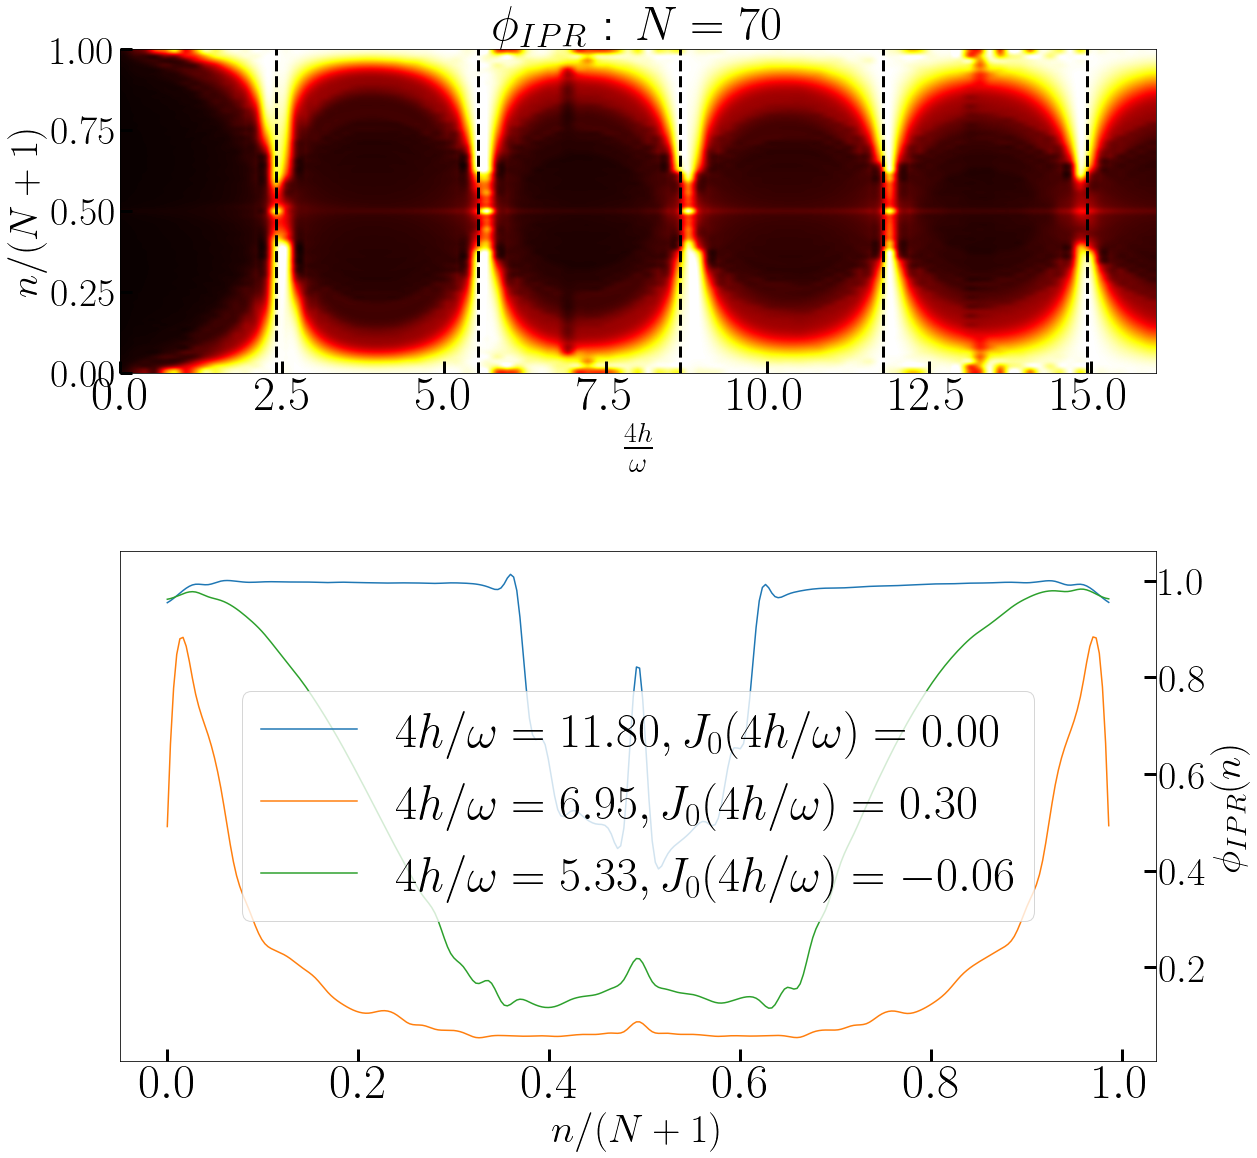

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j0, jn_zeros
plt.rcParams.update({
    "figure.figsize": (20, 20),
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 40,
    "font.sans-serif": ["Computer Modern"]})

from scipy.special import jn_zeros
freezing_pts = jn_zeros(0,5)

import h5py
filename = "iprdata_06_28_2022_12_30_00.hdf5"
f = h5py.File(filename, 'r')
iprmat = np.array(f['iprmat'])
hs = np.array(f['amplitudes'])
N = f['amplitudes'].attrs['N']
omega = f['amplitudes'].attrs['omega']
w = omega

from scipy.interpolate import make_interp_spline


etas = 4 * hs/w
fig = plt.figure(constrained_layout=True)
ipr_ax, crosssec_ax = fig.subplots(2,1)
ipr_ax.set_title(fr'$\phi_{{IPR}}$ : $N = {N}$')
# find minimum of minima & maximum of maxima
minmin = np.min(np.min(iprmat))
maxmax = np.max(np.max(iprmat))
asp = 5
ipr_ax.set_xlabel(r'$\frac{4h}{\omega}$')
ipr_ax.set_ylabel(r'$n/(N+1)$')

for pt in freezing_pts:
    ipr_ax.axvline(x=pt, color='black', linestyle="--",linewidth=3.0)

ipr_ax.imshow(iprmat.T, aspect=asp, interpolation='spline16',\
                cmap='hot', origin='lower',extent = [etas[0] , etas[-1], 0 , 1], vmax=maxmax, vmin=minmin)


#Freezing point
idx, = np.where(np.isclose(etas, freezing_pts[3], atol=0.009))
n0 = idx[0]

#High IPR
idx = np.where(iprmat[20:] == iprmat[20:].min())
n1 = idx[0][0]+20

#Intermediate IPR
idx, = np.where(np.isclose(etas, 5.3, atol=0.09))
n2 = idx[0]

for i, n in enumerate([n0,n1, n2]):
    xdata = np.arange(N+1)/(N+1)
    ydata =  iprmat[n]
    xnew = np.linspace(xdata.min(), xdata.max(), 300)
    gfg = make_interp_spline(xdata, ydata, k=3)
    crosssec_ax.plot(xnew, gfg(xnew), label=fr"$4h/\omega={etas[n]:1.2f}, J_0(4h/\omega)={j0(etas[n]):1.2f}$")

    
crosssec_ax.set_xlabel(r"$n/(N+1)$")
crosssec_ax.yaxis.tick_right()
crosssec_ax.yaxis.set_label_position("right")
crosssec_ax.set_ylabel(r"$\phi_{{IPR}}(n)$")
plt.legend()
plt.show()